# Hypothesis Functionality

## Goals
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

## Important Functions
- Write the Graph
- Learn the CPT Table
- ObserveData: Should be done after CPT Table is created but before hypothesis testing
- findBestExplanation given the observed data and the graph

## TO DO:
- USE SIMILARITY TO JUDGE MULTI-NODE HYPOTHESIS

In [32]:
from similarityfunctions import *
import networkx as nx
from itertools import permutations, combinations

In [33]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    nodes = graph.nodes()
    for i in nodes:
        if i in true_nodes:
            graph.nodes[i]['value'] = 1
        elif i in false_nodes:
            graph.nodes[i]['value'] = 0
        else:
            graph.nodes[i]['value'] = None

In [34]:
class CPT(object):
    """
    Defines a CPT Class
    """
    def __init__(self, num_parents):
        self.num_parents = num_parents
        self.CPTable = self.make_table()
        
    def make_table(self):
        CPTable = {}
        if self.num_parents > 0:
            for i in range(2**self.num_parents):
                CPTable[bin(i)] = 0.0
        else:
            CPTable['self'] = 0.0
        return CPTable
    
    def add_entry(self, parent_values, prob):
        # values of nodes sorted in alphabetical order
        key = ''
        for i in parent_values:
            key += str(i)
        self.CPTable[bin(int(key, 2))] = prob 
    
    def add_entry_self(self, prob):
        self.CPTable['self'] = prob
    
    def get_entry(self, parent_values, value):
        key = ''
        for i in parent_values:
            key += str(i)
        return self.CPTable[bin(int(key, 2))][value]
    
    def get_entry_bin(self, parent_bin, value):
        return self.CPTable[parent_bin][value]
    
    def get_entry_self(self, value):
        return self.CPTable['self'][value]
    
    def get_table(self):
        return self.CPTable

In [35]:
from itertools import product
def calculateMarginalProbability(blanket, knodes):
    sorted_nodes = sorted(blanket.nodes())
    # want to calculate P(hyp | obs)
    # first, calculate marginal probability of P(hyp, obs, nodes)
    
    unodes = [item for item in sorted_nodes if (not item in knodes)]
    keys = list(product(range(2), repeat=len(unodes)))
    prob = 0
    for i in keys:
        p = 1
        for x in sorted_nodes:
            # find the parent values of a node
            parents = sorted(list(blanket.predecessors(x)))
            # if it has parents, get the key and get the probability
            if parents:
                # get the parents:
                parent_values = []
                for z in parents:
                    if z in knodes:
                        parent_values.append(blanket.node[z]['value'])
                    else:
                        parent_values.append(i[unodes.index(z)])
                
                parents_key = bin(int(''.join(map(str, parent_values)), 2))

                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_bin(parents_key, i[unodes.index(x)])
            # if it doesn't have parents, get the entry for itself based on the node value
            else:
                if x in knodes:
                    p *= blanket.node[x]['CPT'].get_entry_self(blanket.node[x]['value'])
                else:
                    p *= blanket.node[x]['CPT'].get_entry_self(i[unodes.index(x)])
        prob += p
    return prob

In [36]:
def calculateTotalMarginalProbability(blanket, hyp, obs, bnodes):
    # hyp | obs
    # obs | hyp
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_obs = list(obs) + list(bnodes)
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_obs)
    return num_prob / denom_prob

def calculateTotalMarginalProbabilityObs(blanket, hyp, obs, bnodes):
    all_obs = []
    all_obs += obs
    all_obs += hyp
    all_obs += bnodes
    new_hyp = list(hyp) + list(bnodes)
    num_prob = calculateMarginalProbability(blanket, all_obs)
    denom_prob = calculateMarginalProbability(blanket, new_hyp)
    return num_prob / denom_prob

In [37]:
# Finds all possible hypothesis
def combinationsList(my_list, start):
    total = []
    for i in range(start, len(my_list) + 1):
        total += list(combinations(my_list, i))
    return total

def findHypotheses(graph, observed_nodes, bnodes):
    all_node_combos = combinationsList(graph.nodes(), 1)
    hyps = []
    for i in all_node_combos:
        children = {}
        for x in i:
            children.update(get_all_children(graph, x, {}, 1))
        if all(item in children.keys() for item in observed_nodes):
            if not any(item in observed_nodes for item in i) and not any(item in bnodes for item in i):
                observed_children = {}
                for x in observed_nodes:
                    observed_children.update(get_all_children(graph, x, {}, 1))
                if not any(item in observed_children for item in i) and not too_similar(graph, i):
                    hyps.append(list(i))
    return hyps

def too_similar(graph, hyp_list, thresh=.5):
    pairs = list(combinations(hyp_list, 2))
    for pair in pairs:
        # if they're too similar
        sim_1 = get_full_similarity(graph, pair[0], pair[1])
        # print(pair, sim_1)
        if sim_1 > thresh or sim_1 == 0:
            return True
    return False

# Finds a bunch of hypothesis. Does nothing yet
def findBestExplanation(graph, observed_nodes, bnodes, flipped=False, hyps=None):
    if hyps is None:
        hyps = findHypotheses(graph, observed_nodes, bnodes)
    current_best = (None, 0)
    hyp_dict = {}
    for i in hyps:
        if isinstance(i, list) or isinstance(i, tuple): 
            for x in i:
                graph.nodes[x]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            for x in i:
                graph.nodes[x]['value'] = None
        else:
            graph.nodes[i]['value'] = 1
            if flipped:
                prob = calculateTotalMarginalProbabilityObs(graph, list(i), observed_nodes, bnodes)
            else:
                prob = calculateTotalMarginalProbability(graph, list(i), observed_nodes, bnodes)
            graph.nodes[i]['value'] = None
        if prob > current_best[1]:
            current_best = (i, prob)
        hyp_dict.update({tuple(i): prob})
    return (hyp_dict, current_best)

In [38]:
def hypothesisSelection(graph, observed_nodes, bnodes, n):
    # observe the data
    
    # first, o | h to
    hyp_dict, current_best = findBestExplanation(graph, observed_nodes, bnodes, flipped=True)
    # get the nth percent (4th, third, half)
    updated_hyps = {}
    lim = int(len(hyp_dict)/n)
    for i in range(lim):
        maximum = max(hyp_dict.values())
        max_key = next((key for key, val in hyp_dict.items() if maximum == val), None)
        updated_hyps.update({max_key: maximum})
        del hyp_dict[max_key]
    new_hyps, final_best = findBestExplanation(graph, observed_nodes, bnodes, hyps=updated_hyps.keys())
    return final_best

In [39]:
def graph_tests(graph, n=2):
    obs_nodes = [item for item in graph.nodes() if len(nx.ancestors(graph, item)) > 0]
    obs_nodes_combos = combinationsList(obs_nodes, 1)
    back_nodes_combos = combinationsList(graph.nodes(), 0)
    
    final_list = []
    for i in back_nodes_combos:
        for x in obs_nodes_combos:
            if not (any(item in i for item in x) and any(item in x for item in i)):
                children = get_all_children(graph, x, {}, 1)
                if not any(item in children for item in i):
                    observeData(graph, x, i)
                    hyp, prob = hypothesisSelection(graph, x, i, n)
                    final_list.append([(x, i, hyp), prob])
    return final_list

## Testing

### Burgler Tests
Based off the example found [HERE](https://www.ics.uci.edu/~rickl/courses/cs-171/2012-wq-cs171/2012-wq-cs171-lecture-slides/2012wq171-17-BayesianNetworks.pdf)

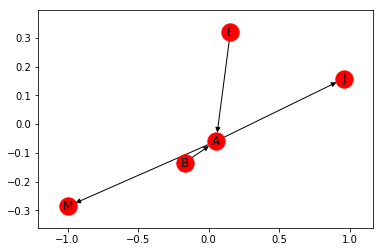

In [40]:
bdg = nx.DiGraph()
bdg.add_nodes_from(['B', 'E', 'A', 'M', 'J'])
bdg.add_weighted_edges_from([('B','A', .94002),('E','A', .29066),('A', 'M',.7),('A','J',.9)])
nx.draw_networkx(bdg)

In [41]:
# learn the CPTable

# burglar
cpt_B = CPT(0)
cpt_B.add_entry_self((1-.001, .001))
bdg.node['B']['CPT'] = cpt_B
# earthquake
cpt_E = CPT(0)
cpt_E.add_entry_self((1-.002, .002))
bdg.node['E']['CPT'] = cpt_E
#alarm
cpt_A = CPT(2)
cpt_A.add_entry([1, 1], (1-.95, .95))
cpt_A.add_entry([1, 0], (1-.94, .94))
cpt_A.add_entry([0, 1], (1-.29, .29))
cpt_A.add_entry([0, 0], (1-.001, .001))
bdg.node['A']['CPT'] = cpt_A
#john calls
cpt_J = CPT(1)
cpt_J.add_entry([1], (1-.9, .9))
cpt_J.add_entry([0], (1-.05, .05))
bdg.node['J']['CPT'] = cpt_J
#mary calls
cpt_M = CPT(1)
cpt_M.add_entry([1], (1-.7, .7))
cpt_M.add_entry([0], (1-.01, .01))
bdg.node['M']['CPT'] = cpt_M

In [42]:
observeData(bdg, ['J', 'M'], [])

In [43]:
findHypotheses(bdg, ['M', 'J'], [])

[['B'], ['E'], ['A'], ['B', 'A']]

In [44]:
findBestExplanation(bdg, ['M', 'J'], [])

({('B',): 0.2841718353643929,
  ('E',): 0.17606683840507922,
  ('A',): 0.7606920388631078,
  ('B', 'A'): 0.284157445461528},
 (['A'], 0.7606920388631078))

In [45]:
findBestExplanation(bdg, ['M', 'J'], [], flipped=True)

({('B',): 0.5922425899999999,
  ('E',): 0.18347047,
  ('A',): 0.63,
  ('B', 'A'): 0.6299999999999999},
 (['A'], 0.63))

In [46]:
hypothesisSelection(bdg, ['M', 'J'], [], n=2)

(('A',), 0.7606920388631078)

In [47]:
bdg_results_unclean = graph_tests(bdg)
bdg_results_clean = [item for item in bdg_results_unclean if item[1] != 0]

In [48]:
bdg_results_unclean

[[(('A',), (), ('B',)), 0.373551228281836],
 [(('M',), (), ('A',)), 0.15009011774975964],
 [(('J',), (), ('A',)), 0.043437711799927066],
 [(('A', 'M'), (), ('B',)), 0.373551228281836],
 [(('A', 'J'), (), ('B',)), 0.37355122828183596],
 [(('M', 'J'), (), ('A',)), 0.7606920388631078],
 [(('A', 'M', 'J'), (), ('B',)), 0.37355122828183596],
 [(('A',), ('B',), None), 0],
 [(('M',), ('B',), ('A',)), 0.09961384529643373],
 [(('J',), ('B',), ('A',)), 0.027661940776723615],
 [(('A', 'M'), ('B',), None), 0],
 [(('A', 'J'), ('B',), None), 0],
 [(('M', 'J'), ('B',), ('A',)), 0.6657108744026019],
 [(('A', 'M', 'J'), ('B',), None), 0],
 [(('A',), ('E',), None), 0],
 [(('M',), ('E',), ('A',)), 0.11971342160945007],
 [(('J',), ('E',), ('A',)), 0.033788238300887834],
 [(('A', 'M'), ('E',), None), 0],
 [(('A', 'J'), ('E',), None), 0],
 [(('M', 'J'), ('E',), ('A',)), 0.7099672469001376],
 [(('A', 'M', 'J'), ('E',), None), 0],
 [(('M',), ('A',), ('B',)), 6.013131697154256e-05],
 [(('J',), ('A',), ('B',)),

In [49]:
sorted(bdg_results_clean)

[[(('A',), (), ('B',)), 0.373551228281836],
 [(('A', 'J'), (), ('B',)), 0.37355122828183596],
 [(('A', 'M'), (), ('B',)), 0.373551228281836],
 [(('A', 'M', 'J'), (), ('B',)), 0.37355122828183596],
 [(('J',), (), ('A',)), 0.043437711799927066],
 [(('J',), ('A',), ('B',)), 6.0131316971542564e-05],
 [(('J',), ('A', 'M'), ('B',)), 6.013131697154255e-05],
 [(('J',), ('B',), ('A',)), 0.027661940776723615],
 [(('J',), ('B', 'M'), ('A',)), 0.008547192182370435],
 [(('J',), ('E',), ('A',)), 0.033788238300887834],
 [(('J',), ('E', 'M'), ('B', 'A')), 0.005083365847947335],
 [(('J',), ('M',), ('A',)), 0.013573889331307635],
 [(('M',), (), ('A',)), 0.15009011774975964],
 [(('M',), ('A',), ('B',)), 6.013131697154256e-05],
 [(('M',), ('A', 'J'), ('B',)), 6.013131697154256e-05],
 [(('M',), ('B',), ('A',)), 0.09961384529643373],
 [(('M',), ('B', 'J'), ('A',)), 0.011511683274678913],
 [(('M',), ('E',), ('A',)), 0.11971342160945007],
 [(('M',), ('E', 'J'), ('A',)), 0.014113094727792633],
 [(('M',), ('J',

### Sprinkler Tests
Example found [here](https://www.bayesserver.com/examples/networks/sprinkler)

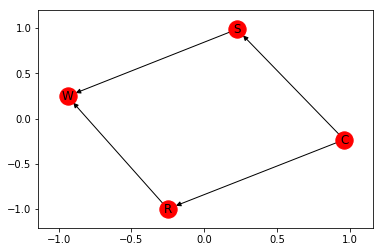

In [50]:
# make the graph
sdg = nx.DiGraph()
sdg.add_nodes_from(['C', 'S', 'R', 'W'])
sdg.add_weighted_edges_from([('C','S', 0),('C','R', 0),('S', 'W', 0),('R','W', 0)])
nx.draw_networkx(sdg)

In [51]:
# learn the CPTable

# Cloudy
cpt_C = CPT(0)
cpt_C.add_entry_self((.5, .5))
sdg.node['C']['CPT'] = cpt_C

# Rain
cpt_R = CPT(1)
cpt_R.add_entry([1], (1-.8, .8))
cpt_R.add_entry([0], (1-.2, .2))
sdg.node['R']['CPT'] = cpt_R

# Sprinkler
cpt_S = CPT(1)
cpt_S.add_entry([1], (1-.1, .1))
cpt_S.add_entry([0], (1-.5, .5))
sdg.node['S']['CPT'] = cpt_S

# Grass Wet
cpt_W = CPT(2)
cpt_W.add_entry([1, 1], (1-.99, .99))
cpt_W.add_entry([1, 0], (1-.9, .9))
cpt_W.add_entry([0, 1], (1-.9, .9))
cpt_W.add_entry([0, 0], (1, 0))
sdg.node['W']['CPT'] = cpt_W

In [52]:
# observe the data
observeData(sdg, ['W', 'C'], [])

In [53]:
# calculate the total marginal probability (both ways)
# hyp | obs
findBestExplanation(sdg, ['W'], ['C'])

({('S',): 0.13043478260869565, ('R',): 0.9758454106280193},
 (['R'], 0.9758454106280193))

In [54]:
# obs | hyp
findBestExplanation(sdg, ['W'], ['C'], flipped=True)

({('S',): 0.9720000000000001, ('R',): 0.909}, (['S'], 0.9720000000000001))

In [55]:
hypothesisSelection(sdg, ['W'], ['C'], n=1)

(('R',), 0.9758454106280193)

In [63]:
sdg_results_unclean = graph_tests(sdg)
sdg_results_clean = [item for item in sdg_results_unclean if item[1] != 0]

In [57]:
sorted(sdg_results_clean)

[[(('W',), (), ('S',)), 0.4297635605006954],
 [(('W',), ('C',), ('R',)), 0.3442622950819672],
 [(('W',), ('R',), ('S',)), 1.0],
 [(('W',), ('S',), ('R',)), 1.0]]

### Asia Tests
Example found [here](https://www.bayesserver.com/examples/networks/asia)

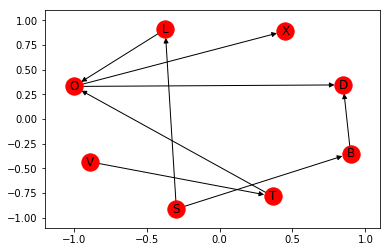

In [58]:
# make the graph
adg = nx.DiGraph()
adg.add_nodes_from(['V', 'T', 'S', 'L', 'B', 'O', 'X', 'D'])
adg.add_weighted_edges_from([('V','T', 0),('T','O', 0),('O','X', 0),
                             ('O','D', 0), ('S','L', 0), ('S','B', 0),
                            ('L','O', 0), ('B','D', 0)])
nx.draw_networkx(adg)

In [59]:
# learn the CPTable

# Visit to Asia
cpt_V = CPT(0)
cpt_V.add_entry_self((.99, .01))
adg.node['V']['CPT'] = cpt_V

# Smoker
cpt_S = CPT(0)
cpt_S.add_entry_self((.5, .5))
adg.node['S']['CPT'] = cpt_S

# Tuburculosis
cpt_T = CPT(1)
cpt_T.add_entry([1], (1-.05, .05))
cpt_T.add_entry([0], (1-.01, .01))
adg.node['T']['CPT'] = cpt_T

# Lung Cancer
cpt_L = CPT(1)
cpt_L.add_entry([1], (1-.1, .1))
cpt_L.add_entry([0], (1-.01, .01))
adg.node['L']['CPT'] = cpt_L

# Bronchitus
cpt_B = CPT(1)
cpt_B.add_entry([1], (1-.6, .6))
cpt_B.add_entry([0], (1-.3, .3))
adg.node['B']['CPT'] = cpt_B

# Tub or Cancer
cpt_O = CPT(2)
cpt_O.add_entry([1, 1], (.01, .99))
cpt_O.add_entry([1, 0], (.01, .99))
cpt_O.add_entry([0, 1], (.01, .99))
cpt_O.add_entry([0, 0], (.99, .01))
adg.node['O']['CPT'] = cpt_O

# Dyspena
cpt_D = CPT(2)
cpt_D.add_entry([1, 1], (1-.9, .9))
cpt_D.add_entry([1, 0], (1-.8, .8))
cpt_D.add_entry([0, 1], (1-.7, .7))
cpt_D.add_entry([0, 0], (1-.1, .1))
adg.node['D']['CPT'] = cpt_D

# Xray result
cpt_X = CPT(1)
cpt_X.add_entry([1], (1-.98, .98))
cpt_X.add_entry([0], (1-.05, .05))
adg.node['X']['CPT'] = cpt_X

In [60]:
# observe the data
observeData(adg, ['O'], ['T', 'L'])

In [61]:
adg_results_unclean = graph_tests(adg)
adg_results_clean = [item for item in adg_results_unclean if item[1] != 0]

In [62]:
sorted(adg_results_clean)

[[(('B',), (), ('S',)), 0.6666666666666663],
 [(('B',), ('L',), ('S',)), 0.6451612903225806],
 [(('B',), ('L', 'O'), ('S',)), 0.6451612903225807],
 [(('B',), ('L', 'O', 'X'), ('S',)), 0.6451612903225808],
 [(('B',), ('L', 'X'), ('S',)), 0.6451612903225806],
 [(('B',), ('O',), ('S',)), 0.6453971152017948],
 [(('B',), ('O', 'X'), ('S',)), 0.6453971152017948],
 [(('B',), ('T',), ('S',)), 0.6666666666666664],
 [(('B',), ('T', 'L'), ('S',)), 0.6451612903225807],
 [(('B',), ('T', 'L', 'O'), ('V', 'S')), 0.006193444076459698],
 [(('B',), ('T', 'L', 'O', 'X'), ('V', 'S')), 0.006193444076459698],
 [(('B',), ('T', 'L', 'X'), ('S',)), 0.6451612903225807],
 [(('B',), ('T', 'O'), ('S', 'L')), 0.0007235366471311771],
 [(('B',), ('T', 'O', 'X'), ('S',)), 0.6453946892410102],
 [(('B',), ('T', 'X'), ('V', 'S')), 0.006200342145321829],
 [(('B',), ('V',), ('S',)), 0.6666666666666666],
 [(('B',), ('V', 'O'), ('S', 'L')), 0.0007307649867110388],
 [(('B',), ('V', 'O', 'X'), ('S',)), 0.6453970209634552],
 [(

In [65]:
final_results = {}
for i in adg_results_clean:
    if i[0][0] in final_results.keys():
        final_results[i[0][0]].append(i)
    else:
        final_results[i[0][0]] = [i]

In [76]:
all_data = []
for i in final_results.keys():
    data = []
    for x in final_results[i]:
        data.append(x[1])
    all_data.append(data)


[Text(0, 0, "('T',)"),
 Text(0, 0, "('L',)"),
 Text(0, 0, "('B',)"),
 Text(0, 0, "('O',)"),
 Text(0, 0, "('X',)"),
 Text(0, 0, "('D',)"),
 Text(0, 0, "('T', 'B')"),
 Text(0, 0, "('T', 'O')"),
 Text(0, 0, "('T', 'X')"),
 Text(0, 0, "('T', 'D')"),
 Text(0, 0, "('L', 'B')")]

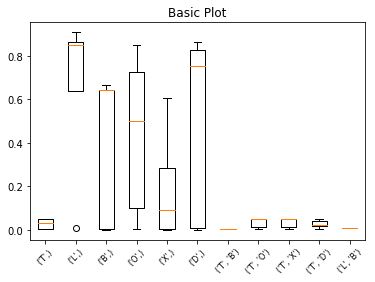

In [85]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(all_data[:int(len(all_data)/4)])
ax1.set_xticklabels(list(final_results.keys())[:int(len(final_results.keys())/4)],
                    rotation=45, fontsize=8)

[Text(0, 0, "('L', 'O')"),
 Text(0, 0, "('L', 'X')"),
 Text(0, 0, "('L', 'D')"),
 Text(0, 0, "('B', 'O')"),
 Text(0, 0, "('B', 'X')"),
 Text(0, 0, "('B', 'D')"),
 Text(0, 0, "('O', 'X')"),
 Text(0, 0, "('O', 'D')"),
 Text(0, 0, "('X', 'D')"),
 Text(0, 0, "('T', 'B', 'O')"),
 Text(0, 0, "('T', 'B', 'X')"),
 Text(0, 0, "('T', 'B', 'D')")]

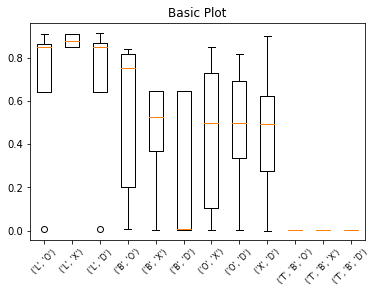

In [86]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(all_data[int(len(all_data)/4):int(len(all_data)/2)])
ax1.set_xticklabels(list(final_results.keys())[int(len(final_results.keys())/4):int(len(final_results.keys())/2)],
                    rotation=45, fontsize=8)

[Text(0, 0, "('T', 'O', 'X')"),
 Text(0, 0, "('T', 'O', 'D')"),
 Text(0, 0, "('T', 'X', 'D')"),
 Text(0, 0, "('L', 'B', 'O')"),
 Text(0, 0, "('L', 'B', 'X')"),
 Text(0, 0, "('L', 'B', 'D')"),
 Text(0, 0, "('L', 'O', 'X')"),
 Text(0, 0, "('L', 'O', 'D')"),
 Text(0, 0, "('L', 'X', 'D')"),
 Text(0, 0, "('B', 'O', 'X')"),
 Text(0, 0, "('B', 'O', 'D')"),
 Text(0, 0, "('B', 'X', 'D')")]

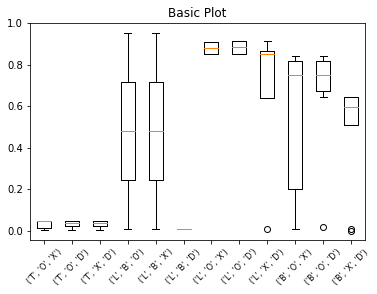

In [94]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(all_data[int(len(all_data)/2):int(3*len(all_data)/4)])
ax1.set_xticklabels(list(final_results.keys())[int(len(final_results.keys())/2):int(3*len(final_results.keys())/4)],
                    rotation=45, fontsize=8)

[Text(0, 0, "('O', 'X', 'D')"),
 Text(0, 0, "('T', 'B', 'O', 'X')"),
 Text(0, 0, "('T', 'B', 'O', 'D')"),
 Text(0, 0, "('T', 'B', 'X', 'D')"),
 Text(0, 0, "('T', 'O', 'X', 'D')"),
 Text(0, 0, "('L', 'B', 'O', 'X')"),
 Text(0, 0, "('L', 'B', 'O', 'D')"),
 Text(0, 0, "('L', 'B', 'X', 'D')"),
 Text(0, 0, "('L', 'O', 'X', 'D')"),
 Text(0, 0, "('B', 'O', 'X', 'D')"),
 Text(0, 0, "('T', 'B', 'O', 'X', 'D')"),
 Text(0, 0, "('L', 'B', 'O', 'X', 'D')")]

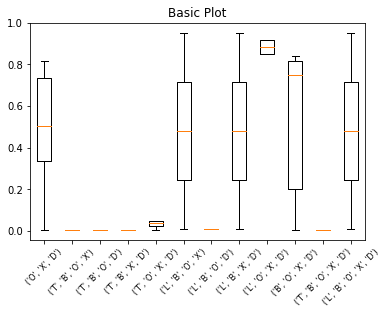

In [95]:
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(all_data[int(3*len(all_data)/4):])
ax1.set_xticklabels(list(final_results.keys())[int(3*len(final_results.keys())/4):],
                    rotation=45, fontsize=8)

## Export data with Pandas

In [32]:
import pandas as pd

In [96]:
adg_results_clean

[[(('T',), (), ('V', 'L')), 0.002644230769230768],
 [(('L',), (), ('S',)), 0.9090909090909092],
 [(('B',), (), ('S',)), 0.6666666666666663],
 [(('O',), (), ('L',)), 0.7404995740597491],
 [(('X',), (), ('O',)), 0.6087027435996738],
 [(('D',), (), ('B',)), 0.8285056930007667],
 [(('T', 'B'), (), ('V', 'S', 'L')), 0.0032051282051282063],
 [(('T', 'O'), (), ('V', 'L')), 0.0026442307692307694],
 [(('T', 'X'), (), ('V', 'L')), 0.0026442307692307685],
 [(('T', 'D'), (), ('V', 'S')), 0.024978598508010267],
 [(('L', 'B'), (), ('V', 'S')), 0.009523809523809525],
 [(('L', 'O'), (), ('S',)), 0.9090909090909091],
 [(('L', 'X'), (), ('S',)), 0.9090909090909092],
 [(('L', 'D'), (), ('S',)), 0.9153548820794353],
 [(('B', 'O'), (), ('S', 'L')), 0.7493310517338158],
 [(('B', 'X'), (), ('S', 'L')), 0.4905756332304992],
 [(('B', 'D'), (), ('S', 'L')), 0.07410082986796963],
 [(('O', 'X'), (), ('L',)), 0.7404995740597489],
 [(('O', 'D'), (), ('L',)), 0.7466782514928717],
 [(('X', 'D'), (), ('O',)), 0.753969

In [108]:
def convert(lst): 
    res_dct = {tuple(lst[i][0]): lst[i][1] for i in range(0, len(lst))} 
    return res_dct 
dict_adg_results_clean = convert(adg_results_clean)

In [109]:
dict_adg_results_clean

{(('T',), (), ('V', 'L')): 0.002644230769230768,
 (('L',), (), ('S',)): 0.9090909090909092,
 (('B',), (), ('S',)): 0.6666666666666663,
 (('O',), (), ('L',)): 0.7404995740597491,
 (('X',), (), ('O',)): 0.6087027435996738,
 (('D',), (), ('B',)): 0.8285056930007667,
 (('T', 'B'), (), ('V', 'S', 'L')): 0.0032051282051282063,
 (('T', 'O'), (), ('V', 'L')): 0.0026442307692307694,
 (('T', 'X'), (), ('V', 'L')): 0.0026442307692307685,
 (('T', 'D'), (), ('V', 'S')): 0.024978598508010267,
 (('L', 'B'), (), ('V', 'S')): 0.009523809523809525,
 (('L', 'O'), (), ('S',)): 0.9090909090909091,
 (('L', 'X'), (), ('S',)): 0.9090909090909092,
 (('L', 'D'), (), ('S',)): 0.9153548820794353,
 (('B', 'O'), (), ('S', 'L')): 0.7493310517338158,
 (('B', 'X'), (), ('S', 'L')): 0.4905756332304992,
 (('B', 'D'), (), ('S', 'L')): 0.07410082986796963,
 (('O', 'X'), (), ('L',)): 0.7404995740597489,
 (('O', 'D'), (), ('L',)): 0.7466782514928717,
 (('X', 'D'), (), ('O',)): 0.7539691772010959,
 (('T', 'B', 'O'), (), ('V'

In [110]:
dict_df = pd.DataFrame({ key:pd.Series(value) for key, value in dict_adg_results_clean.items() })

In [111]:
dict_df

(T,)      (L,)      (B,)    (O,)      (X,)      (D,)    (T, B)  \
         ()        ()        ()      ()        ()        ()        ()   
     (V, L)      (S,)      (S,)    (L,)      (O,)      (B,) (V, S, L)   
0  0.002644  0.909091  0.666667  0.7405  0.608703  0.828506  0.003205   

     (T, O)    (T, X)    (T, D)  ...            (X,)            (D,)  \
         ()        ()        ()  ... (V, L, B, O, D) (T, S, L, B, X)   
     (V, L)    (V, L)    (V, S)  ...            (T,)          (V, O)   
0  0.002644  0.002644  0.024979  ...        0.000102        0.000014   

             (X,)            (D,)                            (X,)  \
  (T, S, L, B, D) (T, S, L, O, X) (T, S, B, O, X) (T, S, B, O, D)   
           (V, O)            (B,)          (V, L)            (V,)   
0        0.000594        0.774194    9.793755e-07          0.0096   

             (D,)            (X,)            (D,)            (X,)  
  (T, L, B, O, X) (T, L, B, O, D) (S, L, B, O, X) (S, L, B, O, D)  
           (V, S)          (V, S)            (T,)            (V,)  
0        0.003282        0.003282        0.000106        0.009604  

[1 rows x 558 columns]

In [ ]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [ ]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True

In [ ]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    #get all parent nodes
    edge_attrs = nx.get_edge_attributes(graph, 'weight')
    new_graph = nx.DiGraph()
    new_graph.add_node(hyp)
    new_graph.add_nodes_from(obs)
    for i in edge_attrs:
        if i[0] in obs or i[0] == hyp:
            new_graph.add_node(i[1])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
        if i[1] in obs or i[1] == hyp:
            new_graph.add_node(i[0])
            new_graph.add_edge(i[0], i[1], weight=edge_attrs[i])
    return new_graph